# Exoplanet exploration using Machine Learning

### Load all necessary libraries

In [ ]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.metrics import recall_score, precision_score, classification_report,accuracy_score,confusion_matrix, roc_curve, auc, roc_curve,accuracy_score,plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns

### Load the testing and training data

In [20]:
test_data = pd.read_csv('./data/exoTest.csv')
train_data = pd.read_csv('./data/exoTrain.csv')

In [67]:
print(test_data.columns)


Index(['LABEL', 'FLUX.1', 'FLUX.2', 'FLUX.3', 'FLUX.4', 'FLUX.5', 'FLUX.6',
       'FLUX.7', 'FLUX.8', 'FLUX.9',
       ...
       'FLUX.3188', 'FLUX.3189', 'FLUX.3190', 'FLUX.3191', 'FLUX.3192',
       'FLUX.3193', 'FLUX.3194', 'FLUX.3195', 'FLUX.3196', 'FLUX.3197'],
      dtype='object', length=3198)


In [28]:
train_data

LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
0         2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
1         2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
2         2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
3         2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
4         2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   
...     ...      ...      ...      ...      ...      ...      ...     ...   
5082      1   -91.91   -92.97   -78.76   -97.33   -68.00   -68.24  -75.48   
5083      1   989.75   891.01   908.53   851.83   755.11   615.78  595.77   
5084      1   273.39   278.00   261.73   236.99   280.73   264.90  252.92   
5085      1     3.82     2.09    -3.29    -2.88     1.66    -0.75    3.85   
5086      1   323.28   306.36   293.16   287.67   249.89   218.30  188.86   

       FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0      -96.27  -79.89  ...     -78.07    -102.15    -102.15      25.13   
1      -85.33  -83.97  ...      -3.28     -32.21     -32.21     -24.89   
2      486.39  436.56  ...     -71.69      13.31      13.31     -29.89   
3      311.31  312.42  ...       5.71      -3.73      -3.73      30.05   
4    -1022.71 -989.57  ...    -594.37    -401.66    -401.66    -357.24   
...       ...     ...  ...        ...        ...        ...        ...   
5082   -49.25  -30.92  ...     139.95     147.26     156.95     155.64   
5083   458.87  492.84  ...     -26.50      -4.84     -76.30     -37.84   
5084   254.88  237.60  ...     -26.82     -53.89     -48.71      30.99   
5085    -0.03    3.28  ...      10.86      -3.23      -5.10      -4.61   
5086   178.93  118.93  ...      71.19       0.97      55.20      -1.63   

      FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0         48.57      92.54      39.32      61.42       5.08     -39.54  
1         -4.86       0.76     -11.70       6.46      16.00      19.93  
2        -20.88       5.06     -11.80     -28.91     -70.02     -96.67  
3         20.03     -12.67      -8.77     -17.31     -17.35      13.98  
4       -443.76    -438.54    -399.71    -384.65    -411.79    -510.54  
...         ...        ...        ...        ...        ...        ...  
5082     156.36     151.75     -24.45     -17.00       3.23      19.28  
5083    -153.83    -136.16      38.03     100.28     -45.64      35.58  
5084      15.96      -3.47      65.73      88.42      79.07      79.43  
5085      -9.82      -1.50      -4.65     -14.55      -6.41      -2.55  
5086      -5.50     -25.33     -41.31     -16.72     -14.09      27.82  

[5087 rows x 3198 columns]

Now the target column LABEL consists of two categories 1(Does not represents exoplanet) and 2(represents the presence of exoplanet). So, convert them to binary values for easier processing of data.

In [29]:
categ = {2: 1,1: 0}
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]

In [30]:
train_data.describe()

LABEL        FLUX.1        FLUX.2        FLUX.3        FLUX.4  \
count  5087.000000  5.087000e+03  5.087000e+03  5.087000e+03  5.087000e+03   
mean      0.007273  1.445054e+02  1.285778e+02  1.471348e+02  1.561512e+02   
std       0.084982  2.150669e+04  2.179717e+04  2.191309e+04  2.223366e+04   
min       0.000000 -2.278563e+05 -3.154408e+05 -2.840018e+05 -2.340069e+05   
25%       0.000000 -4.234000e+01 -3.952000e+01 -3.850500e+01 -3.505000e+01   
50%       0.000000 -7.100000e-01 -8.900000e-01 -7.400000e-01 -4.000000e-01   
75%       0.000000  4.825500e+01  4.428500e+01  4.232500e+01  3.976500e+01   
max       1.000000  1.439240e+06  1.453319e+06  1.468429e+06  1.495750e+06   

             FLUX.5        FLUX.6        FLUX.7        FLUX.8        FLUX.9  \
count  5.087000e+03  5.087000e+03  5.087000e+03  5.087000e+03  5.087000e+03   
mean   1.561477e+02  1.469646e+02  1.168380e+02  1.144983e+02  1.228639e+02   
std    2.308448e+04  2.410567e+04  2.414109e+04  2.290691e+04  2.102681e+04   
min   -4.231956e+05 -5.975521e+05 -6.724046e+05 -5.790136e+05 -3.973882e+05   
25%   -3.195500e+01 -3.338000e+01 -2.813000e+01 -2.784000e+01 -2.683500e+01   
50%   -6.100000e-01 -1.030000e+00 -8.700000e-01 -6.600000e-01 -5.600000e-01   
75%    3.975000e+01  3.514000e+01  3.406000e+01  3.170000e+01  3.045500e+01   
max    1.510937e+06  1.508152e+06  1.465743e+06  1.416827e+06  1.342888e+06   

       ...     FLUX.3188     FLUX.3189     FLUX.3190     FLUX.3191  \
count  ...  5.087000e+03  5.087000e+03  5.087000e+03  5.087000e+03   
mean   ...  3.485578e+02  4.956476e+02  6.711211e+02  7.468790e+02   
std    ...  2.864786e+04  3.551876e+04  4.349963e+04  4.981375e+04   
min    ... -3.240480e+05 -3.045540e+05 -2.933140e+05 -2.838420e+05   
25%    ... -1.760000e+01 -1.948500e+01 -1.757000e+01 -2.076000e+01   
50%    ...  2.600000e+00  2.680000e+00  3.050000e+00  3.590000e+00   
75%    ...  2.211000e+01  2.235000e+01  2.639500e+01  2.909000e+01   
max    ...  1.779338e+06  2.379227e+06  2.992070e+06  3.434973e+06   

          FLUX.3192     FLUX.3193      FLUX.3194      FLUX.3195  \
count  5.087000e+03  5.087000e+03    5087.000000    5087.000000   
mean   6.937372e+02  6.553031e+02    -494.784966    -544.594264   
std    5.087103e+04  5.339979e+04   17844.469520   17722.339334   
min   -3.288214e+05 -5.028894e+05 -775322.000000 -732006.000000   
25%   -2.226000e+01 -2.440500e+01     -26.760000     -24.065000   
50%    3.230000e+00  3.500000e+00      -0.680000       0.360000   
75%    2.780000e+01  3.085500e+01      18.175000      18.770000   
max    3.481220e+06  3.616292e+06  288607.500000  215972.000000   

           FLUX.3196      FLUX.3197  
count    5087.000000    5087.000000  
mean     -440.239100    -300.536399  
std     16273.406292   14459.795577  
min   -700992.000000 -643170.000000  
25%       -21.135000     -19.820000  
50%         0.900000       1.430000  
75%        19.465000      20.280000  
max    207590.000000  211302.000000  

[8 rows x 3198 columns]

Now visualize the target column in the train_dataset and get an idea about the class distribution.

In [31]:
train_data['LABEL'].value_counts()

LABEL
0    5050
1      37
Name: count, dtype: int64

We have 5050 records of non-exoplanets and 37 records of exoplanets.

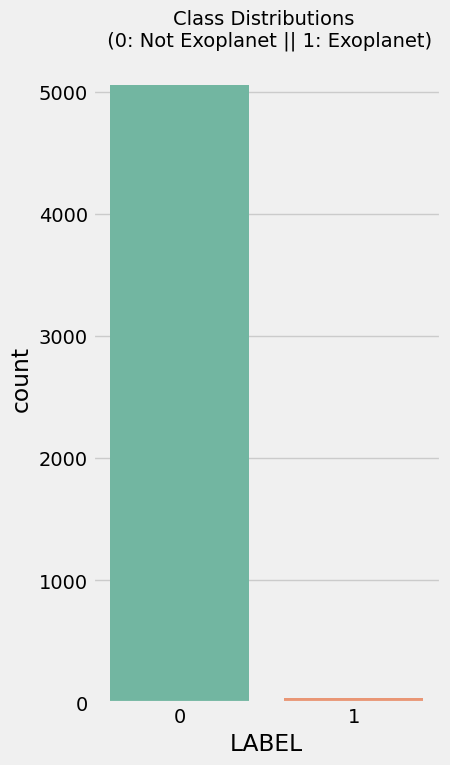

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,8))
colors = ["0", "1"]
sns.countplot(x='LABEL', data=train_data, palette="Set2")  # Pass the column name 'LABEL' to the x parameter
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)
plt.show()


It turns out that the data is highly imbalanced so later on we'll be using some sampling techniques to balance the data.

### Plotting heatmap of missing values

<Axes: >

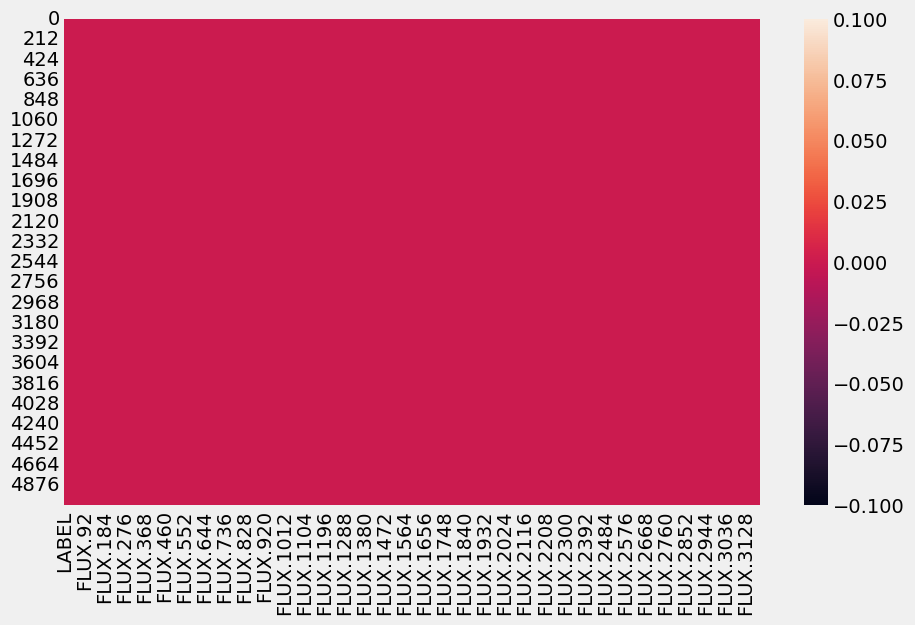

In [38]:
sns.heatmap(train_data.isnull())

We can clearly see that we dont have any missing values in our dataset.

Flux : the intensity of light recived from a planet

### Let us plot the first 4 rows of the train data and observe the intensity of flux values.

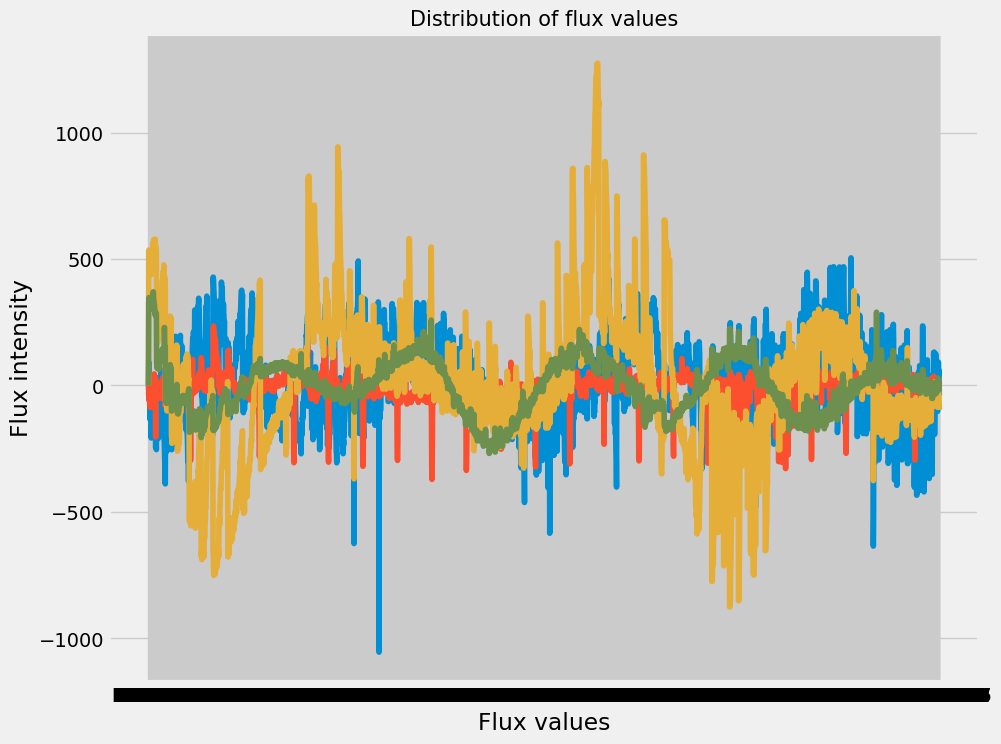

In [39]:
plt.figure(figsize=(10,8))
plt.title('Distribution of flux values', fontsize=15)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(train_data.iloc[0,])
plt.plot(train_data.iloc[1,])
plt.plot(train_data.iloc[2,])
plt.plot(train_data.iloc[3,])
plt.show()

### Plotting the correlation matrix

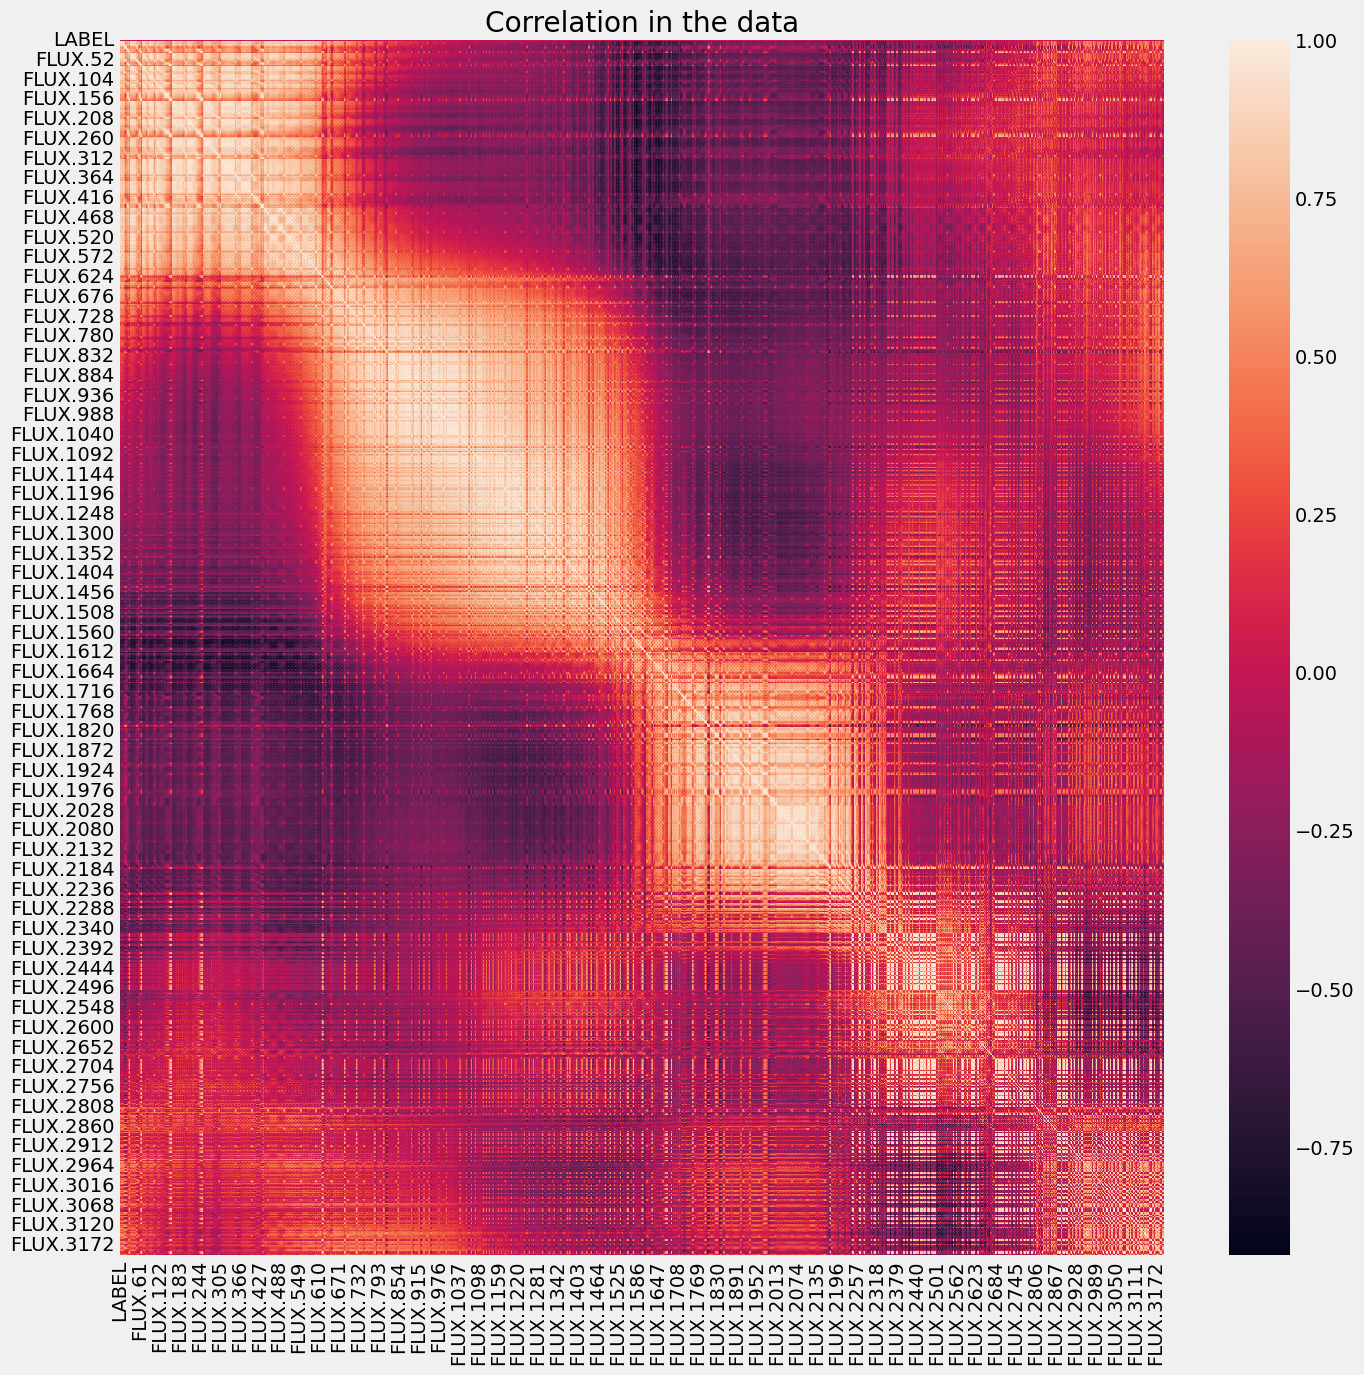

In [42]:
plt.figure(figsize=(15,15))
sns.heatmap(train_data.corr())
plt.title('Correlation in the data')
plt.show()

### Plot the Gaussian histogram of non-exoplanets data

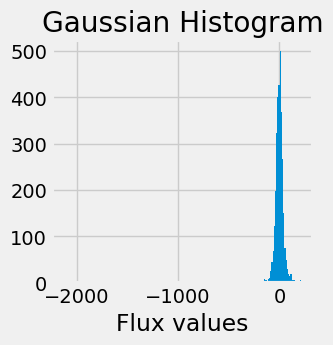

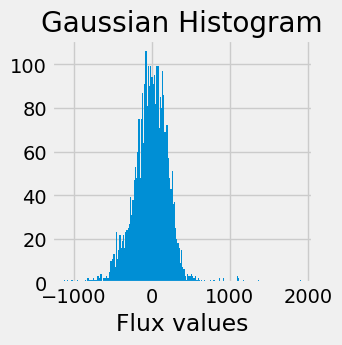

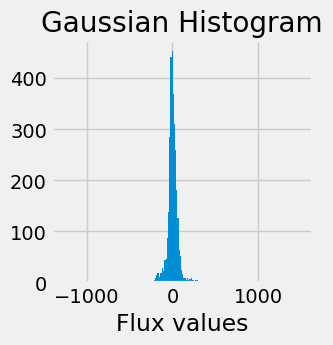

In [43]:
labels_1=[100,200,300]
for i in labels_1:
    plt.figure(figsize=(3,3))
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

### Plot Gaussian histogram of the data when exoplanets are present

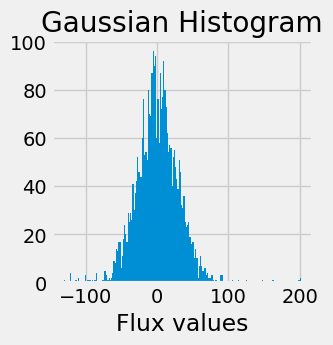

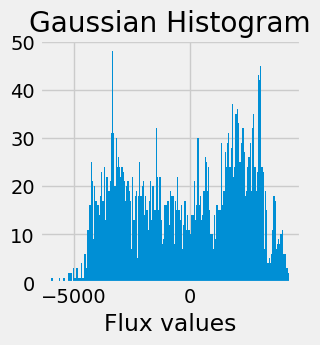

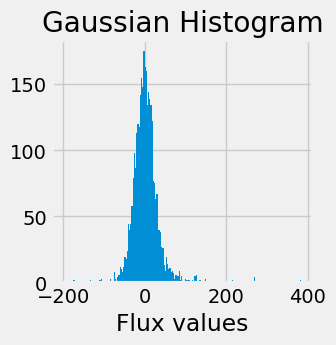

In [44]:
labels_1=[16,21,25]
for i in labels_1:
    plt.figure(figsize=(3,3))
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

### Detecting outliers using Boxplot

Box Plot is the visual representation of the depicting groups of numerical data through their quartiles. Boxplot is also used for detect the outlier in data set. It captures the summary of the data efficiently with a simple box and whiskers and allows us to compare easily across groups. Boxplot summarizes a sample data using 25th, 50th and 75th percentiles.

<Axes: xlabel='LABEL', ylabel='FLUX.5'>

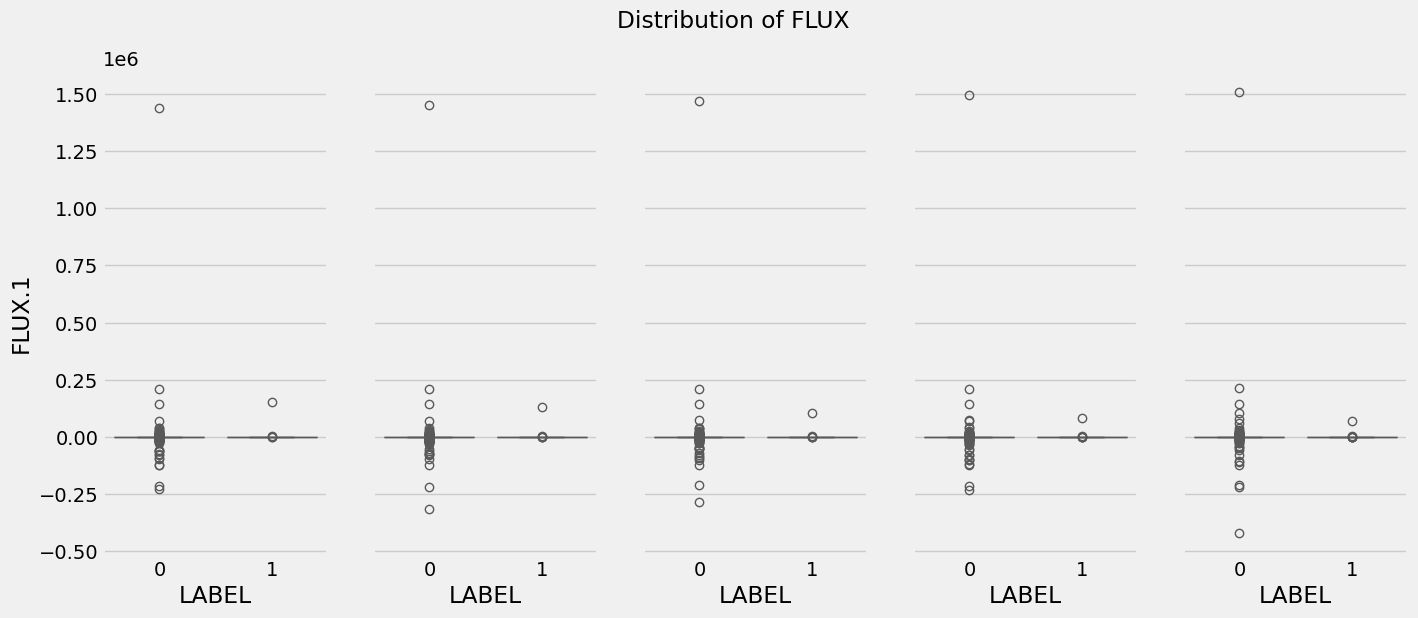

In [45]:
fig, axes = plt.subplots(1, 5,figsize=(15, 6), sharey=True)
fig.suptitle('Distribution of FLUX')

sns.boxplot(ax=axes[0], data=train_data, x='LABEL', y='FLUX.1',palette="Set2")
sns.boxplot(ax=axes[1], data=train_data, x='LABEL', y='FLUX.2',palette="Set2")
sns.boxplot(ax=axes[2], data=train_data, x='LABEL', y='FLUX.3',palette="Set2")
sns.boxplot(ax=axes[3], data=train_data, x='LABEL', y='FLUX.4',palette="Set2")
sns.boxplot(ax=axes[4], data=train_data, x='LABEL', y='FLUX.5',palette="Set2")

In [46]:
print('Dropping Outliers')
train_data.drop(train_data[train_data['FLUX.1']>250000].index, axis=0, inplace=True)

Dropping Outliers


### Split the dataset

So let us first split our dataset and normalize it.

In [47]:
x_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
x_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

### Data Normalization

Data Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

In [49]:
from sklearn.preprocessing import normalize

x_train = normalized = normalize(x_train)
x_test = normalize(x_test)


### Apply gaussian filters

The next step is to apply gaussian filters to both test and train.

In probability theory, the normal (or Gaussian or Gauss or Laplace–Gauss) distribution is a very common continuous probability distribution. Normal distributions are important in statistics and are often used in the natural and social sciences to represent real-valued random variables whose distributions are not known.

In [51]:
from scipy import ndimage

x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

### Feature scaling

We use feature scaling so that all the values remain in the comparable range.

In [53]:
from sklearn.preprocessing import StandardScaler

# Feature scaling
std_scaler = StandardScaler()
x_train = std_scaler.fit_transform(x_train)  # Fit and transform on the training set
x_test = std_scaler.transform(x_test)        # Only transform on the test set


### Model Building

Validation accuracy of KNN is 0.9912280701754386

Classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

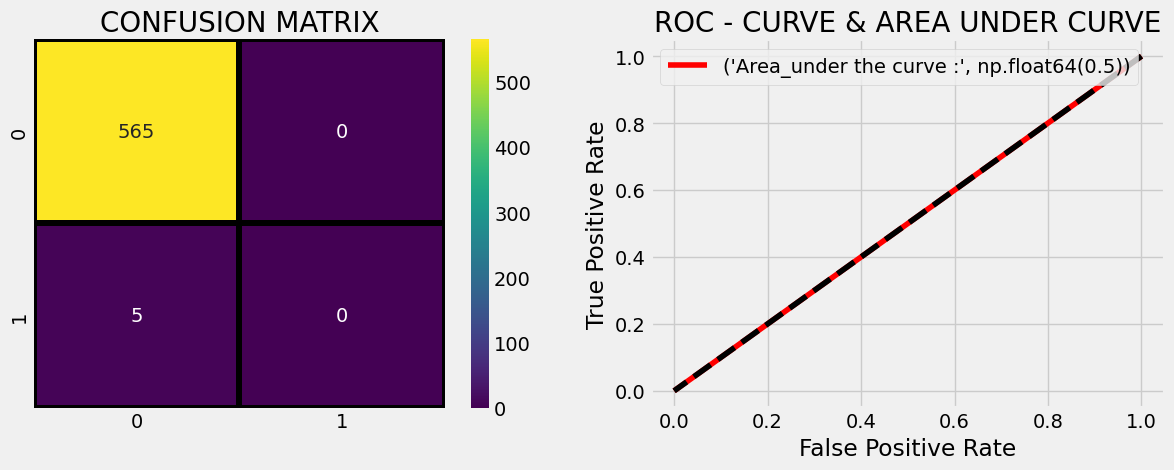

In [54]:
#K-NN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()

knn_model.fit(x_train,y_train)
prediction=knn_model.predict(x_test)
print('Validation accuracy of KNN is', accuracy_score(prediction,y_test))
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = knn_model.predict_proba(x_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

Validation accuracy of Logistic Regression is 0.9912280701754386

Classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

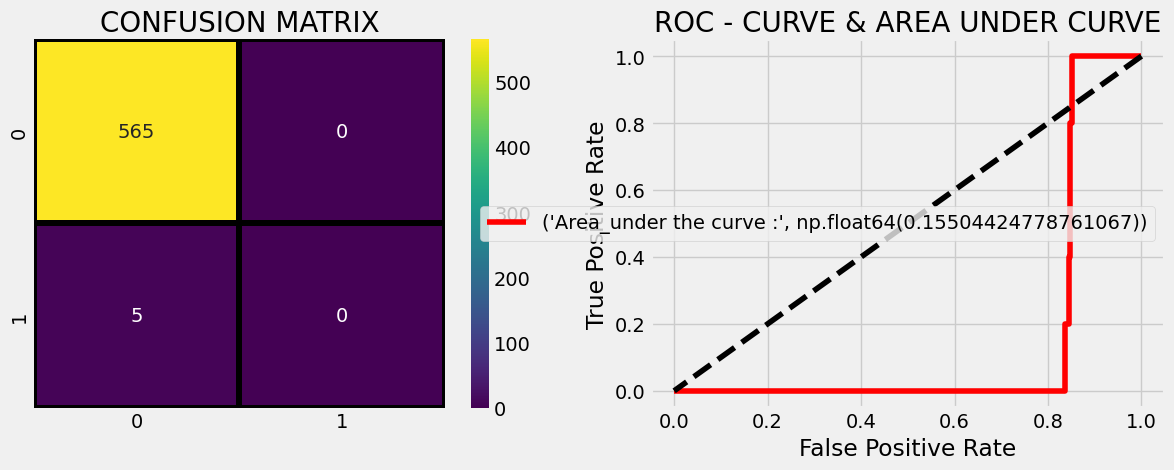

In [55]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(class_weight={0:100, 1:1})

lr_model.fit(x_train,y_train)

prediction=lr_model.predict(x_test)

print('Validation accuracy of Logistic Regression is', accuracy_score(prediction,y_test))
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = lr_model.predict_proba(x_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

Validation accuracy of Decision Tree is 0.9912280701754386

Classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

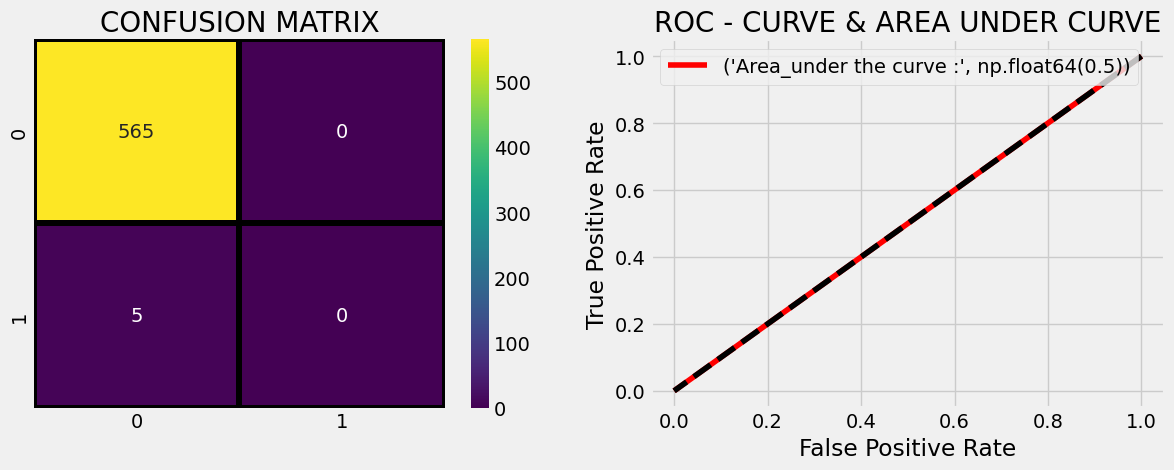

In [56]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
ds_model = DecisionTreeClassifier(max_depth=5, random_state=13)

ds_model.fit(x_train,y_train)

prediction=ds_model.predict(x_test)

print('Validation accuracy of Decision Tree is', accuracy_score(prediction,y_test))
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = ds_model.predict_proba(x_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

Since the dataset is highly imbalanced even if the model predicts the same class for all data points the accuracy.

So let us first balance the classes and model it again.

### Balancing the class using SMOTE

SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them. SMOTE synthesises new minority instances between existing minority instances.

<Axes: xlabel='LABEL'>

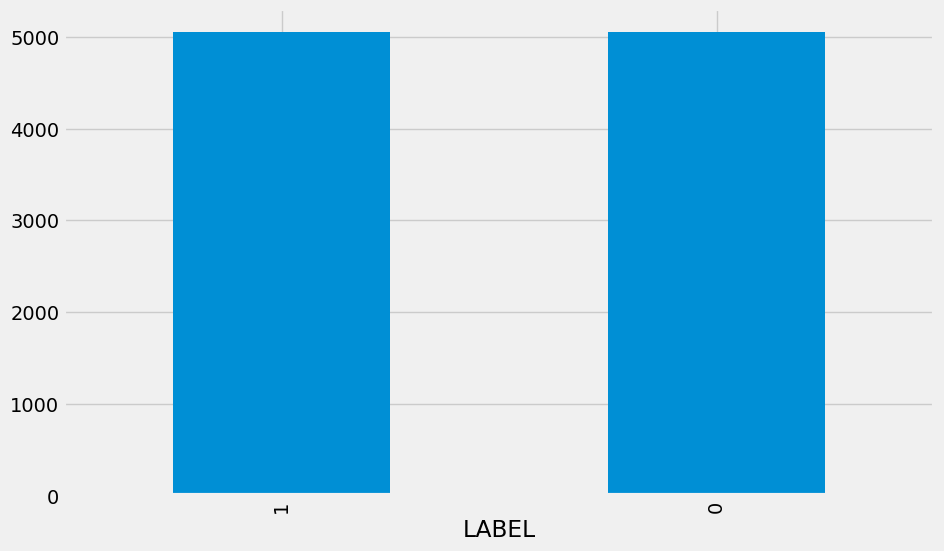

In [62]:
from imblearn.over_sampling import SMOTE

# Instantiate the SMOTE model
model = SMOTE()

# Apply SMOTE to oversample the data
ov_train_x, ov_train_y = model.fit_resample(train_data.drop('LABEL', axis=1), train_data['LABEL'])

# Convert the labels to integers
ov_train_y = ov_train_y.astype('int')

# Plot the value counts of the oversampled labels
value_counts = ov_train_y.value_counts().reset_index()
value_counts.columns = ['LABEL', 'count']  # Rename the columns
value_counts.plot(kind='bar', x='LABEL', y='count', legend=False)


### Split the dataset

In [69]:
train_X, test_X, train_y, test_y = train_test_split(ov_train_x, ov_train_y, test_size=0.33, random_state=42)

Validation accuracy of Decision Tree is 0.9156915691569157

Classification report :
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      1709
           1       0.86      0.99      0.92      1624

    accuracy                           0.92      3333
   macro avg       0.92      0.92      0.92      3333
weighted avg       0.93      0.92      0.92      3333



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

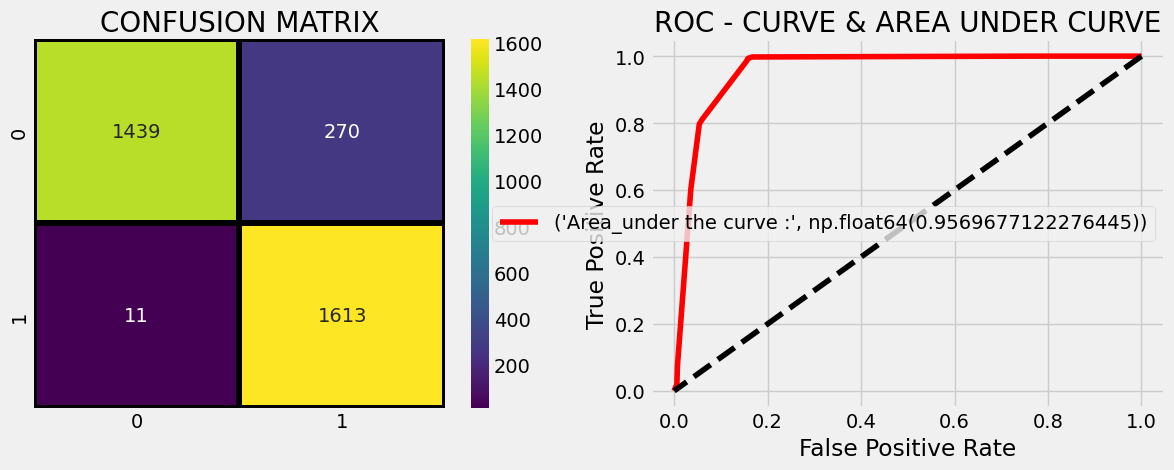

In [64]:
from sklearn.tree import DecisionTreeClassifier
ds_model = DecisionTreeClassifier(max_depth=5, random_state=13)

ds_model.fit(train_X,train_y)

prediction=ds_model.predict(test_X)

print('Validation accuracy of Decision Tree is', accuracy_score(prediction,test_y))
print ("\nClassification report :\n",(classification_report(test_y,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = ds_model.predict_proba(test_X)[:,1]
fpr,tpr,thresholds = roc_curve(test_y,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

Validation accuracy of KNN is 0.9810981098109811

Classification report :
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      1709
           1       0.96      1.00      0.98      1624

    accuracy                           0.98      3333
   macro avg       0.98      0.98      0.98      3333
weighted avg       0.98      0.98      0.98      3333



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

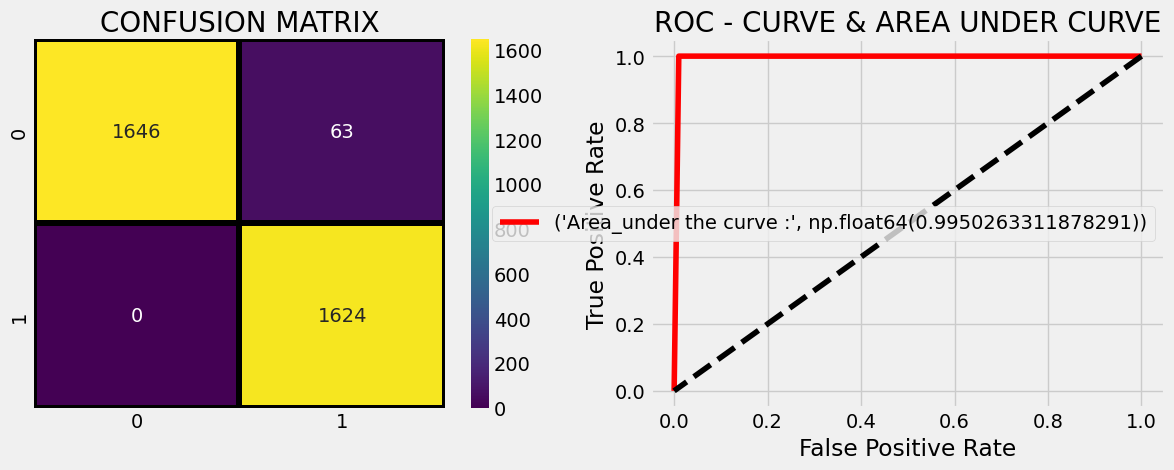

In [65]:
knn_model = KNeighborsClassifier()

knn_model.fit(train_X,train_y)

prediction=knn_model.predict(test_X)

print('Validation accuracy of KNN is', accuracy_score(prediction,test_y))
print ("\nClassification report :\n",(classification_report(test_y,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = knn_model.predict_proba(test_X)[:,1]
fpr,tpr,thresholds = roc_curve(test_y,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

Validation accuracy of Logistic Regression is 0.7005700570057005

Classification report :
               precision    recall  f1-score   support

           0       0.73      0.66      0.69      1709
           1       0.67      0.74      0.71      1624

    accuracy                           0.70      3333
   macro avg       0.70      0.70      0.70      3333
weighted avg       0.70      0.70      0.70      3333



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

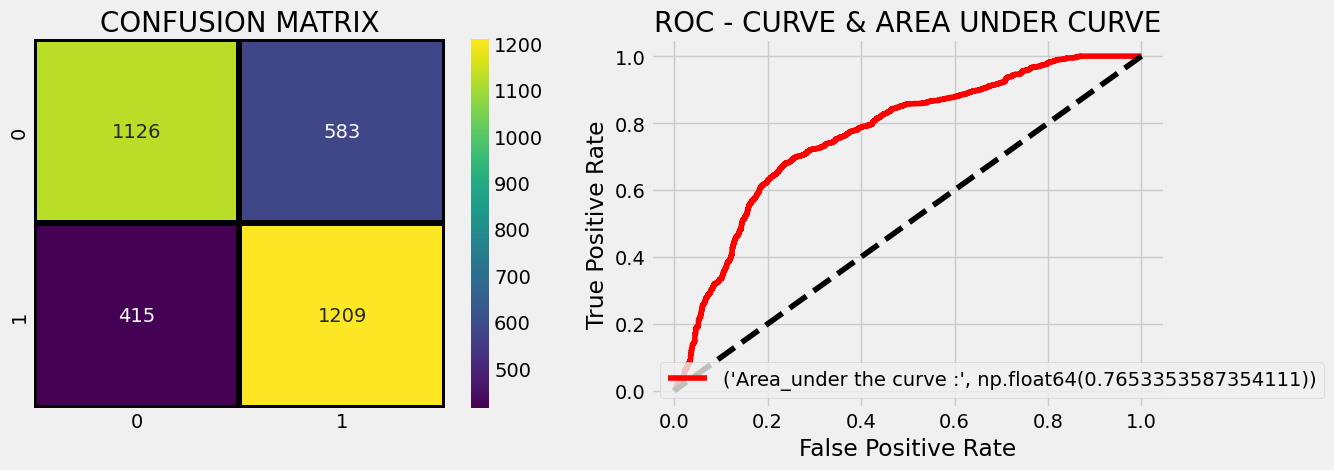

In [66]:
lr_model = LogisticRegression(class_weight={0:100, 1:1})

lr_model.fit(train_X,train_y)

prediction=lr_model.predict(test_X)

print('Validation accuracy of Logistic Regression is', accuracy_score(prediction,test_y))
print ("\nClassification report :\n",(classification_report(test_y,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = lr_model.predict_proba(test_X)[:,1]
fpr,tpr,thresholds = roc_curve(test_y,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)


As we can observe after applying SMOTE to balance the classes, our ML models are performing really good.